## catboost_multiclass_param_opt
## V8
Creates Catboost multiclass classifiers
with hyperparameter optimalization

# 0. Initialization

## Options

In [320]:
#using csv from new version of scraper
new_version = True
#using 502525 split, probably takes a bit longer for hyperopt
split502525 = True
#using optimization (else values from old long optimization)
optimization = True
#using long optimization
#NOTE: is much longer!
long_optimization = True
#save model
save_model = True
#evaluation metric
eval_m = 'TotalF1'

## Dependencies

In [321]:
import numpy as np #math
import pandas as pd #dataframes
import catboost as ct #main machine learning

import sklearn as sk #statistics

import seaborn as sn #plots
import matplotlib.pyplot as plt  #plots
import shap #plots

from hyperopt import hp, fmin, tpe, STATUS_OK #hyperparameter optimalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from dython.nominal import associations

## Main function definitions

## Objective
Objective function for hyperopt for hyperparameter optimalisation

In [322]:
obj_call_count = 0
best_loss = np.inf

def objective(space):
    global obj_call_count, best_loss

    obj_call_count += 1
    
    #train model with parameters from space
    model = ct.CatBoostClassifier(iterations = 500, #not too many
                                  learning_rate = space['learning_rate'],
                                  depth = int(space['depth']),
                                  rsm = space['rsm'],
                                  loss_function = 'MultiClass',
                                  eval_metric = eval_m,
                                  l2_leaf_reg = space['l2_leaf_reg'],
                                  #crashes kernel but might work on your pc
                                  #should increase speed
                                  #devices= '1',
                                  #task_type= 'GPU',
                                  random_seed=42,
                                  verbose=False,
                                  od_type='Iter', #overfitting detector to stop early
                                  od_wait=100
                                  )
    model.fit(val)
    
    #obtain loss
    y_pred = model.predict_proba(x_train)
    #y_pred = model.predict(x_val)
    loss = sk.metrics.log_loss(r_train, y_pred)
    #loss = -sk.metrics.accuracy_score(r_val, y_pred)
    #l = model.eval_metrics(val, ['AUC'])
    #loss = -l[0][-1]
    #if better loss found for new parameters
    if loss<best_loss: 
        best_loss = loss

    return{'loss':loss, 'status': STATUS_OK }

# 1. Data

## Read in data
and some extra analysis

In [324]:
data = pd.read_csv("tweets_bitch.csv") 
print(len(data))
data.head(5)

1932


,Unnamed: 0,Unnamed: 0.1,id_str,Screen Name,User Name,Time,Followers,num_retweets,num_likes,date,...,reply,quote,tweet_type,num_emojis,emoji_polarity,length,party_affiliation,days_since_post,time_day,day_week
0,0,0,1.210867e+18,pvdabelgie,PVDA België,2019-12-28 10:17:26,10460,5,19,2019-12-28,...,False,False,normal,0,0.0,191,pvdabelgie,5,10,5
1,1,1,1.209871e+18,pvdabelgie,PVDA België,2019-12-25 16:16:48,10460,14,30,2019-12-25,...,False,False,normal,0,0.0,87,pvdabelgie,8,16,2
2,2,2,1.207912e+18,pvdabelgie,PVDA België,2019-12-20 06:33:56,10460,13,43,2019-12-20,...,False,False,normal,0,0.0,109,pvdabelgie,13,6,4
3,3,3,1.207627e+18,pvdabelgie,PVDA België,2019-12-19 11:39:33,10460,3,4,2019-12-19,...,False,False,normal,0,0.0,65,pvdabelgie,14,11,3
4,4,4,1.206876e+18,pvdabelgie,PVDA België,2019-12-17 09:58:19,10460,21,51,2019-12-17,...,False,False,normal,0,0.0,83,pvdabelgie,16,9,1


In [325]:
from datetime import datetime
from datetime import date
from sklearn.preprocessing import RobustScaler, StandardScaler
robust = RobustScaler(quantile_range = (0.1,0.9))
scaler = StandardScaler()

#target
scal = data.num_likes/data.Followers*100
if split502525 == True:
    target_med = scal.ge(0.092778723) #medium 50
    target_good = scal.ge(0.31737635) #good 75
else:
    target_med = scal.ge(0.043159258) #medium 33
    target_good = scal.ge(0.210837023) #good 66
data['target'] = 'bad'
data.loc[target_med == True, 'target'] = 'medium'
data.loc[target_good == True, 'target'] = 'good'

#numerical features
feature_cols = ['time_day', 'day_week', 'num_hashtags', 'num_hashtags_trending', 'num_mentions', 'num_urls', 'num_emojis', 'emoji_polarity', 'subjectivity', 'polarity', 'length', 'days_since_post'] 
X = data.loc[:, feature_cols].astype('float')

#categorical and boolean features
feature_cols = ['reply', 'quote', 'category', 'party_affiliation', 'media_type']
#feature_cols = ['tweet_type', 'category', 'party_affiliation', 'media_type']
#feature_cols = ['media_type', 'reply', 'quote', 'category']
#feature_cols = ['media_type', 'tweet_type', 'category']
#feature_cols = ['media_type', 'reply', 'quote']
X[feature_cols] = data.loc[:, feature_cols].astype('category')
target = data['target'].astype('category')

X.head(8)

,time_day,day_week,num_hashtags,num_hashtags_trending,num_mentions,num_urls,num_emojis,emoji_polarity,subjectivity,polarity,length,days_since_post,reply,quote,category,party_affiliation,media_type
0,10.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.25,0.182292,191.0,5.0,False,False,andere,pvdabelgie,nothing
1,16.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.000000,87.0,8.0,False,False,sociaal,pvdabelgie,nothing
2,6.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.000000,109.0,13.0,False,False,politiek,pvdabelgie,nothing
3,11.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.000000,65.0,14.0,False,False,ecologie,pvdabelgie,nothing
4,9.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.000000,83.0,16.0,False,False,politiek,pvdabelgie,nothing
5,11.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.25,-0.083333,209.0,17.0,False,False,economie,pvdabelgie,photo
6,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.60,-0.600000,68.0,17.0,False,False,zorg,pvdabelgie,nothing
7,15.0,3.0,4.0,0.0,2.0,1.0,0.0,0.0,0.00,0.000000,185.0,21.0,True,True,ecologie,pvdabelgie,photo


## Data manipulations

In [326]:
X['category'] = X['category'].fillna('andere')
#X['num_urls'] = X['num_urls']+X['quote'].astype(int)
#X = X.drop(['quote'], axis=1)

#Scaling is not necesary in this type of model, if you want it, change cell to 'code'
X['days_since_post'] = scaler.fit_transform(X.days_since_post.values.reshape(-1, 1))
X['length'] = scaler.fit_transform(X.length.values.reshape(-1, 1))
X['num_urls'] = scaler.fit_transform(X.num_urls.values.reshape(-1, 1))
X['num_hashtags'] = scaler.fit_transform(X.num_hashtags.values.reshape(-1, 1))
X['num_hashtags_trending'] = scaler.fit_transform(X.num_hashtags_trending.values.reshape(-1, 1))
X['num_mentions'] = scaler.fit_transform(X.num_mentions.values.reshape(-1, 1))
X['num_emojis'] = scaler.fit_transform(X.num_emojis.values.reshape(-1, 1))
X['emoji_polarity'] = scaler.fit_transform(X.emoji_polarity.values.reshape(-1, 1))
X['polarity'] = scaler.fit_transform(X.polarity.values.reshape(-1, 1))
X['time_day'] = X['time_day']/24
X['day_week'] = X['day_week']/6

X.head(10)
print(len(X))
print(X)

## Histograms

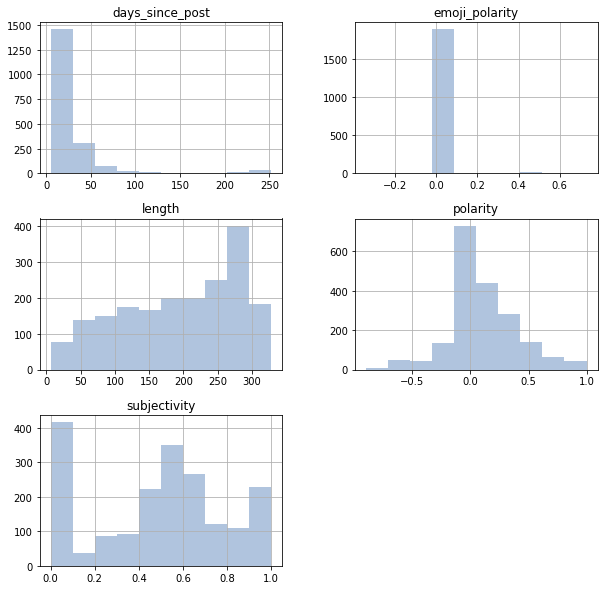

In [327]:
#histograms of float features or integer features with lots of different datapoints
X.hist(column=["length", "subjectivity", "polarity", "days_since_post", "emoji_polarity"], figsize = (10, 10), color = 'lightsteelblue')
plt.show()

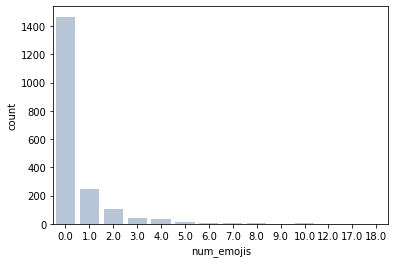

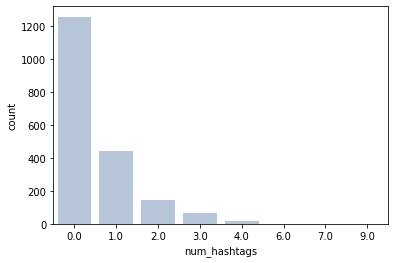

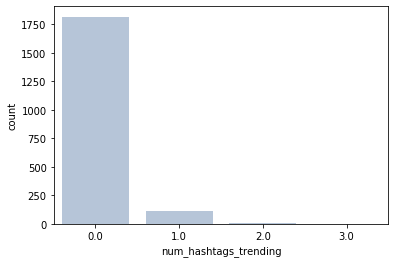

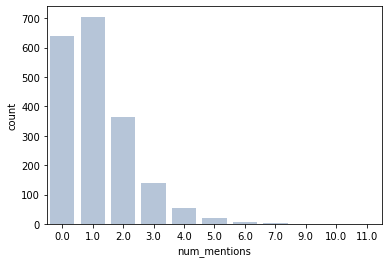

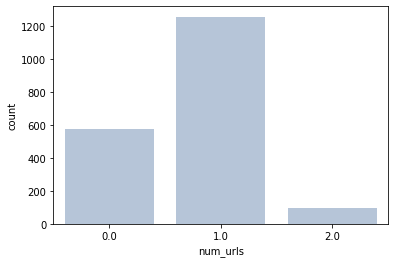

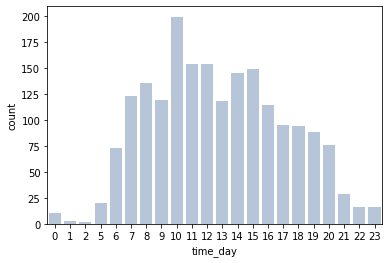

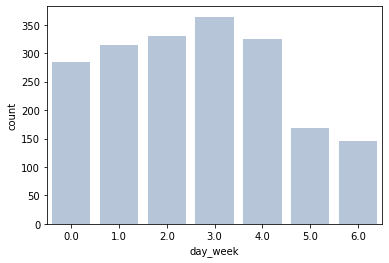

In [350]:
X_c = X.copy()
#histograms of integer features
p = sn.countplot(X['num_emojis'].astype(int), color = 'lightsteelblue')
plt.show()
p = sn.countplot(X['num_hashtags'].astype(int), color = 'lightsteelblue')
plt.show()
p = sn.countplot(X['num_hashtags_trending'].astype(int), color = 'lightsteelblue')
plt.show()
p = sn.countplot(X['num_mentions'].astype(int), color = 'lightsteelblue')
plt.show()
p = sn.countplot(X['num_urls'].astype(int), color = 'lightsteelblue')
plt.show()
p = sn.countplot(X['time_day'].astype(int), color = 'lightsteelblue')
plt.show()
p = sn.countplot(X['day_week'].astype(int), color = 'lightsteelblue')
plt.show()

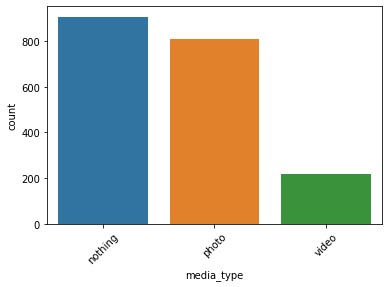

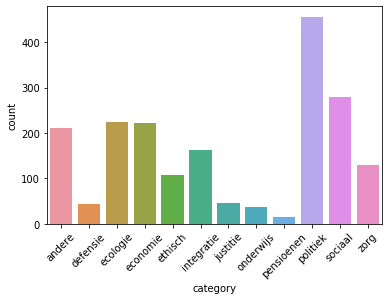

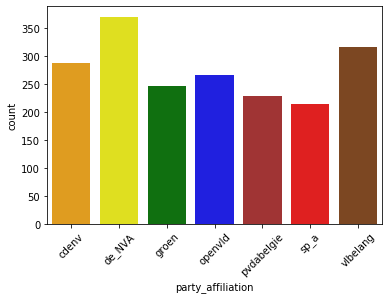

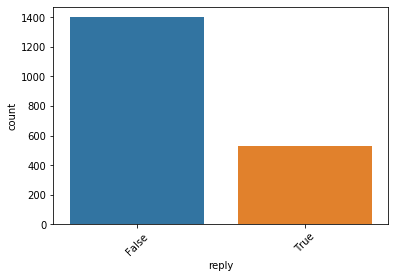

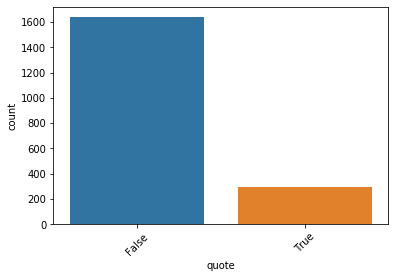

In [329]:
#fig, ax =plt.subplots(1,5)
p = sn.countplot(X['media_type'])
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show()
p = sn.countplot(X['category'])
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show()
palette ={"cdenv":"orange","de_NVA":"yellow","groen":"green", "openvld":"blue", "sp_a":"red","pvdabelgie":"firebrick", "vlbelang":"saddlebrown"}
p = sn.countplot(X['party_affiliation'], palette=palette)
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show()
#p = sn.countplot(X['tweet_type'])
p = sn.countplot(X['reply'])
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show()
p = sn.countplot(X['quote'])
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show()
#sn.countplot(X['media_type' ,'reply' ,'quote' ,'category' 'screen_name'], color = 'blue')

## Correlation matrix

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


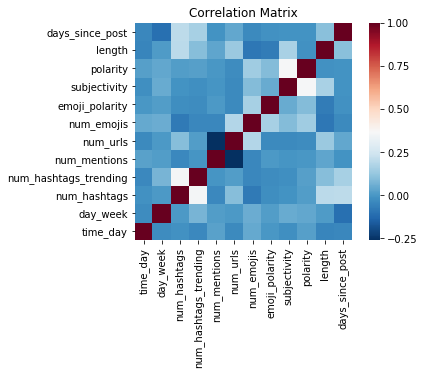

In [330]:
#correlation matrix only taking into account numeric features
correlation = X_c.corr(method='spearman')

fig = plt.figure()

plt.clf()
plt.title('Correlation Matrix')
#ax = plt.subplots(figsize=(20,15))

ax = fig.add_subplot(111)
ax.set_aspect(1)

#plt.subplots(figsize=(20,15))

#ax.set_aspect(1)
cmap = "RdBu_r"
#cmap = sn.cubehelix_palette(light=1, as_cmap=True) #not clear enough
#pl = sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns,cmap=cmap)

pl = sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap = cmap)

#pl = sn.heatmap(correlation, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap=cmap)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
pl.invert_yaxis()

plt.savefig('correlation_matrix.png', dpi=100, bbox_inches='tight' )

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


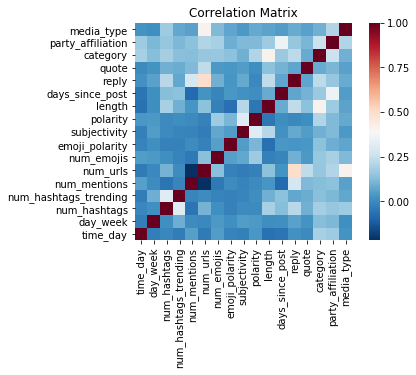

In [331]:
#correlation matrix taking into account categorical features
#Pearson's R for continuous-continuous cases
#Correlation Ratio for categorical-continuous cases
#Cramer's V for categorical-categorical cases
#correlation = associations(X_c, nominal_columns=['tweet_type','category', 'party_affiliation' , 'media_type'], plot = None, return_results = True, nan_strategy = 'drop_samples')
correlation = associations(X_c, nominal_columns=['reply', 'quote', 'category', 'party_affiliation' , 'media_type'], plot = None, return_results = True, nan_strategy = 'drop_samples')

fig = plt.figure()

plt.clf()
plt.title('Correlation Matrix')
#ax = plt.subplots(figsize=(20,15))

ax = fig.add_subplot(111)
ax.set_aspect(1)

#ax.set_aspect(1)
cmap = "RdBu_r"
#cmap = sn.cubehelix_palette(light=1, as_cmap=True) #not clear enough
#pl = sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns,cmap=cmap)

pl = sn.heatmap(correlation,xticklabels=correlation.columns, yticklabels=correlation.columns, cmap = cmap)
#pl = sn.heatmap(correlation, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap=cmap)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
pl.invert_yaxis()

In [332]:
print(correlation)

                       time_day  day_week  num_hashtags  \
time_day               1.000000 -0.031451     -0.007819   
day_week              -0.031451  1.000000      0.017013   
num_hashtags          -0.007819  0.017013      1.000000   
num_hashtags_trending -0.036747  0.091350      0.316969   
num_mentions           0.054814  0.005887     -0.054603   
num_urls              -0.041993 -0.000141      0.103978   
num_emojis             0.050751  0.041306      0.016945   
emoji_polarity        -0.013518  0.017556     -0.020365   
subjectivity          -0.026931  0.051732      0.005018   
polarity               0.034682  0.041984      0.003453   
length                -0.061905  0.013603      0.189088   
days_since_post       -0.055320  0.015846      0.132982   
reply                  0.021127  0.057901      0.223778   
quote                  0.003095  0.027846      0.098044   
category               0.187374  0.133827      0.185559   
party_affiliation      0.170962  0.119093      0.157062 

In [333]:
#emoji_polarity was determined to be useless 
#X = X.drop(['emoji_polarity'], axis=1)

In [334]:
#get non-numeric or boolean features
cat_feat_ind = np.where(X.dtypes != float)[0]
print(cat_feat_ind)

[12 13 14 15 16]


In [335]:
# Randomly split off a test set of approximately 20% of the data
# Split of rest of the data in a validation set for hyperopt (20% of the rest) and a train set (80% of the rest)
test_fraction = 0.2
x_t, x_test, r_t, r_test = train_test_split(X,
                                            target,
                                            stratify = target,
                                            test_size = test_fraction,
                                            random_state=42)

x_train, x_val, r_train, r_val = train_test_split(x_t,
                                                  r_t,
                                                  stratify = r_t,
                                                  test_size = test_fraction,
                                                  random_state=42)
x_train.head(5)

,time_day,day_week,num_hashtags,num_hashtags_trending,num_mentions,num_urls,num_emojis,emoji_polarity,subjectivity,polarity,length,days_since_post,reply,quote,category,party_affiliation,media_type
369,15.0,2.0,0.0,0.0,0.0,1.0,5.0,0.0,0.683333,0.500000,105.0,8.0,False,True,andere,groen,nothing
476,7.0,4.0,1.0,0.0,1.0,1.0,2.0,0.0,0.733333,0.426667,278.0,13.0,False,False,politiek,sp_a,photo
198,20.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.333333,0.166667,285.0,6.0,True,False,pensioenen,pvdabelgie,nothing
1890,19.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.700000,0.300000,152.0,15.0,False,True,integratie,vlbelang,photo
70,16.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.566667,0.133333,304.0,28.0,False,False,sociaal,pvdabelgie,photo


# 2. Hyperparameter optimalization

In [336]:
train = ct.Pool(data=x_train,label=r_train, cat_features=cat_feat_ind)

val = ct.Pool(data=x_val,label=r_val, cat_features=cat_feat_ind)

In [337]:
if optimization == True:
    if long_optimization == True:
        #create hyperopt space
        space ={
            'depth': hp.quniform("depth", 8, 14, 1),#long
            'rsm': hp.uniform ('rsm', 0.75, 1.0),
            'learning_rate': hp.loguniform('learning_rate', -4.5, -0.1),#long
            'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
           }
        #run hyperopt to select best parameters
        best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 150)
        
        
    else:
        #create hyperopt space
        if split502525 == True:
            space ={
                'depth': hp.quniform("depth", 9, 13, 1),
                'rsm': hp.uniform ('rsm', 0.75, 1.0),
                'learning_rate': hp.loguniform('learning_rate', -3.0, -0.7),
                'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
               }
        else:
            space ={
                'depth': hp.quniform("depth", 6, 10, 1),
                'rsm': hp.uniform ('rsm', 0.75, 1.0),
                'learning_rate': hp.loguniform('learning_rate', -3.0, -0.7),
                'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
                
               }
        #run hyperopt to select best parameters
        best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100)
 

else: #no optimization, takes values from old long optimization
    if split502525 == True:
        best = {'depth': 12.0, 'l2_leaf_reg': 7.78380845835078, 'learning_rate': 0.6386696771438192, 'rsm': 0.9968005211083372}
    else:
        #best = {'depth': 9.0, 'l2_leaf_reg': 5.621613823798751, 'learning_rate': 0.0929118003727113, 'rsm': 0.9854929894687339}
        best = {'depth': 9.0, 'l2_leaf_reg': 7.278435815407734, 'learning_rate': 0.051009037062987046, 'rsm': 0.9203368506475921}
print('-'*50)
print('Best parameters:')
print( best )
print('\n\n')

100%|██████████| 150/150 [57:23<00:00, 22.95s/it, best loss: 0.7895756974215663] 
--------------------------------------------------
Best parameters:
{'depth': 10.0, 'l2_leaf_reg': 5.789544776950549, 'learning_rate': 0.06565563695637684, 'rsm': 0.9618452511178559}





# 3. Model

In [338]:
#train multiple models on train set using best parameters, with different seeds to take average prediction
model1 = ct.CatBoostClassifier(iterations = 2500,
                               learning_rate = best['learning_rate'],
                               l2_leaf_reg = best['l2_leaf_reg'],
                               depth = best['depth'],
                               rsm = best['rsm'],
                               loss_function = 'MultiClass',
                               eval_metric = eval_m,
                               use_best_model = True,
                               random_seed = 42,
                               logging_level = 'Silent')
model1.fit(train, eval_set=val)
#model1.fit(train)
#parameters same as model 1
model2 = ct.CatBoostClassifier(iterations=2500,
                               learning_rate=best['learning_rate'],
                               l2_leaf_reg=best['l2_leaf_reg'],
                               depth=best['depth'],
                               rsm=best['rsm'],
                               loss_function= 'MultiClass',
                               eval_metric=eval_m,
                               use_best_model = True,
                               #random_seed=23,
                               logging_level='Silent')
model2.fit(train, eval_set=val)
#model2.fit(train)
model3 = ct.CatBoostClassifier(iterations=2500,
                               learning_rate=best['learning_rate'],
                               l2_leaf_reg=best['l2_leaf_reg'],
                               depth=best['depth'],
                               rsm=best['rsm'],
                               loss_function= 'MultiClass',
                               eval_metric=eval_m,
                               use_best_model = True,
                               #random_seed=12,
                               logging_level='Silent')
model3.fit(train, eval_set=val)
#model3.fit(train)

model4 = ct.CatBoostClassifier(iterations=2500,
                               learning_rate=best['learning_rate'],
                               l2_leaf_reg=best['l2_leaf_reg'],
                               depth=best['depth'],
                               rsm=best['rsm'],
                               loss_function= 'MultiClass',
                               eval_metric=eval_m,
                               use_best_model = True,
                               #random_seed=43,
                               logging_level='Silent')
model4.fit(train, eval_set=val)
#model4.fit(train)

model5 = ct.CatBoostClassifier(iterations=2500,
                               learning_rate=best['learning_rate'],
                               l2_leaf_reg=best['l2_leaf_reg'],
                               depth=best['depth'],
                               rsm=best['rsm'],
                               loss_function= 'MultiClass',
                               eval_metric=eval_m,
                               use_best_model = True,
                               #random_seed=54,
                               logging_level='Silent')
model5.fit(train, eval_set=val)
#model5.fit(train)

#predict using test set
y_pred1 = model1.predict(x_test)
y_pred2 = model2.predict(x_test)
y_pred3 = model3.predict(x_test)
y_pred4 = model4.predict(x_test)
y_pred5 = model5.predict(x_test)


In [339]:
#print(model1.eval_metrics(val, ['TotalF1']))

In [340]:
y_comp = pd.concat([pd.Series(np.ravel(y_pred1)), pd.Series(np.ravel(y_pred2)), pd.Series(np.ravel(y_pred3)), pd.Series(np.ravel(y_pred4)),pd.Series(np.ravel(y_pred5))],axis=1)
y_mean = y_comp.mode(axis=1).iloc[:, 0] #choose prediction that is most frequent per tweet
y_mean.head(8) #show 8 first predictions of the mean predictor
y_comp.head(8) #show 8 first predictions of the 5 predictors


,0,1,2,3,4
0,good,good,good,good,good
1,good,good,good,good,good
2,medium,medium,medium,medium,medium
3,medium,medium,medium,medium,medium
4,medium,medium,medium,medium,medium
5,bad,bad,bad,bad,bad
6,bad,bad,bad,bad,bad
7,good,good,good,good,good


# 4. Analysis

## Feature importance

In [341]:
model1.get_feature_importance(prettified=True)

,Feature Id,Importances
0,party_affiliation,24.332515
1,reply,21.484413
2,category,12.396615
3,media_type,7.203212
4,length,5.011898
5,num_mentions,4.919228
6,days_since_post,4.814656
7,subjectivity,4.318936
8,time_day,3.341235
9,num_hashtags,3.296805


## Performance metrics
Accuracy and confusion matrix for the single and mean predictor

In [342]:
from catboost.utils import get_confusion_matrix
print("Accuracy for mean predictor")
accuracy_mean = sk.metrics.accuracy_score(r_test, y_mean)
print(accuracy_mean)
print("Confusion matrix for mean predictor")
confusion_mean = sk.metrics.confusion_matrix(r_test, y_mean, labels=['bad', 'medium', 'good'])
print(confusion_mean)
print("Accuracy for single predictor")
accuracy_1 = sk.metrics.accuracy_score(r_test, np.ravel(y_pred1))
print(accuracy_1)
print("Confusion matrix for single predictor")
confusion_1 = sk.metrics.confusion_matrix(r_test, np.ravel(y_pred1), labels=['bad', 'medium', 'good'])
print(confusion_1)
#only for 2 classes
#precision = sk.metrics.precision_score(r_test, np.ravel(y_mean))
#print(precion)

Accuracy for mean predictor
0.6770025839793282
Confusion matrix for mean predictor
[[156  20  14]
 [ 32  30  32]
 [ 12  15  76]]
Accuracy for single predictor
0.661498708010336
Confusion matrix for single predictor
[[158  20  12]
 [ 32  28  34]
 [ 13  20  70]]


## Visual confusion matrix

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


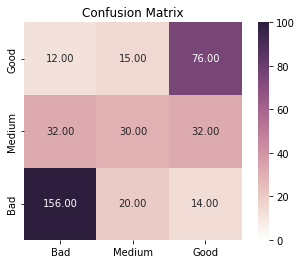

In [343]:
df_cm = pd.DataFrame(confusion_mean, 
  index = [ 'Bad', 'Medium', 'Good'],
  columns = ['Bad', 'Medium', 'Good'])

fig = plt.figure()

plt.clf()
plt.title('Confusion Matrix')
plt.yticks([0.5,1.5,2.5], [ 'Bad', 'Medium', 'Good'],va='center')

ax = fig.add_subplot(111)
ax.set_aspect(1)

cmap = sn.cubehelix_palette(light=1, as_cmap=True)

pl = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap=cmap)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
pl.invert_yaxis()

if split502525 == True:
    plt.savefig('./conf/confusion_matrix50.png', dpi=100, bbox_inches='tight' )
else:
    plt.savefig('./conf/confusion_matrix33F1.png', dpi=100, bbox_inches='tight' )
#plt.close()

## Shap plots
For feature importance

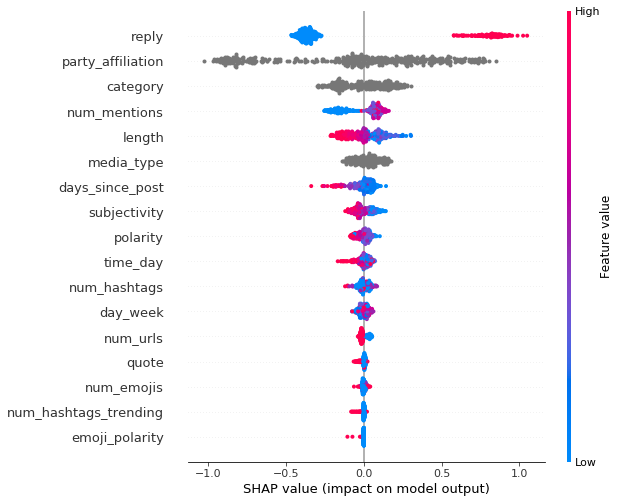

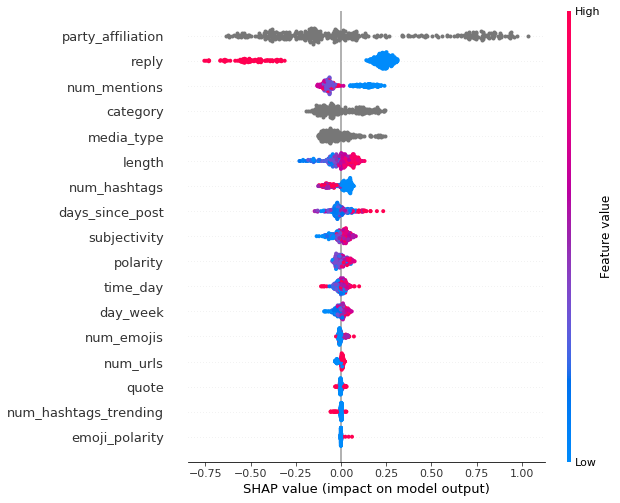

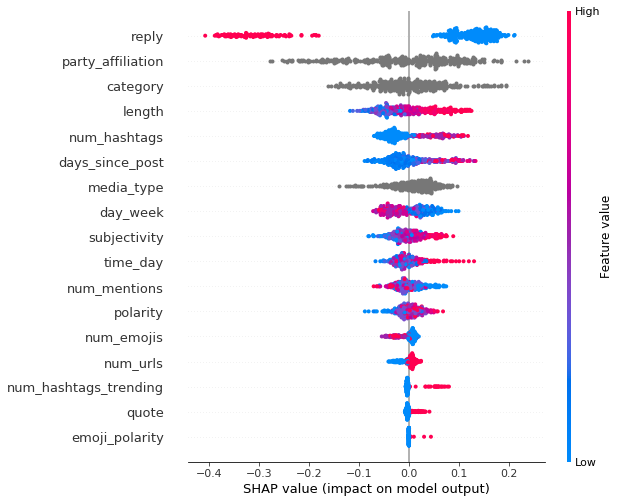

In [348]:
shap.initjs()
shap_values = model1.get_feature_importance(ct.Pool(x_test, r_test, cat_features=cat_feat_ind), type='ShapValues')

shap_values = shap_values[:,:,:-1]
shap.summary_plot(shap_values[:,0], x_test)#class 0
shap.summary_plot(shap_values[:,1], x_test)#class 1
shap.summary_plot(shap_values[:,2], x_test)#class 2

In [349]:
print(shap_values)

[[[ 2.57869531e-02  8.81356906e-03  2.00170724e-02 ...  3.61164988e-02
   -6.51325162e-01 -1.91701983e-02]
  [-9.87562622e-03  1.45935174e-02  1.07221820e-02 ... -4.93412988e-02
    6.47150609e-01 -6.79073119e-03]
  [-1.59113268e-02 -2.34070865e-02 -3.07392544e-02 ...  1.32248000e-02
    4.17455276e-03  2.59609295e-02]]

 [[-8.76846982e-03 -2.04529620e-02  1.31549712e-02 ...  5.16093132e-02
   -5.72888492e-01 -7.93845448e-03]
  [-9.95586008e-03 -1.43418915e-03  1.69374267e-02 ... -5.68950000e-02
    5.58772050e-01 -7.78496702e-03]
  [ 1.87243299e-02  2.18871511e-02 -3.00923979e-02 ...  5.28568679e-03
    1.41164424e-02  1.57234215e-02]]

 [[-1.43155217e-02  6.04496778e-03 -1.01780370e-02 ...  1.03069417e-01
    2.99902790e-02  2.28825248e-02]
  [-5.49029606e-04 -1.04362501e-02  4.16657617e-02 ... -1.16255321e-01
   -7.90516931e-02 -8.31176369e-02]
  [ 1.48645513e-02  4.39128233e-03 -3.14877246e-02 ...  1.31859046e-02
    4.90614141e-02  6.02351121e-02]]

 ...

 [[-1.35807392e-01 -3.610

# 5. Save Models

In [345]:
if save_model == True:
    
    pool = ct.Pool(x_train, r_train, cat_features=cat_feat_ind)


    if split502525 == True:
        #Catboost binary model for fast predictions
        model1.save_model('models/model1-50.cbm', format = "cbm", pool = pool) #pool necessary because categorical features
        model2.save_model('models/model2-50.cbm', format = "cbm", pool = pool)
        model3.save_model('models/model3-50.cbm', format = "cbm", pool = pool)
        model4.save_model('models/model4-50.cbm', format = "cbm", pool = pool)
        model5.save_model('models/model5-50.cbm', format = "cbm", pool = pool)
    else:
        model1.save_model('models/model1-33.cbm', format = "cbm", pool = pool)
        model2.save_model('models/model2-33.cbm', format = "cbm", pool = pool)
        model3.save_model('models/model3-33.cbm', format = "cbm", pool = pool)
        model4.save_model('models/model4-33.cbm', format = "cbm", pool = pool)
        model5.save_model('models/model5-33.cbm', format = "cbm", pool = pool)